<a href="https://colab.research.google.com/github/LaloG/technical-discussion/blob/main/gan_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

mghbm
<img src="https://cloudstate.eu/wp-content/uploads/2019/09/GAN-%E2%80%93-AI-generuj%C4%85ca-rzeczywisto%C5%9B%C4%87.png">

In [ ]:
import os

import tensorflow as tf
from  imageio import imread, imwrite
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import time

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Helper constants

In [ ]:
TRAIN_DATASET_PATH = "gdrive/MyDrive/Colab Notebooks/Datasets/cityscapes/train_formatted"
TEST_DATASET_PATH = "gdrive/MyDrive/Colab Notebooks/Datasets/cityscapes/val_formatted"
CK_PATH = "gdrive/MyDrive/Colab Notebooks/Modelos/Pix2Pix/checkpoints"
GENERATED_IMAGES_PATH = "gdrive/MyDrive/Colab Notebooks/Modelos/Pix2Pix/generated_images"

TRAIN_FILES_LIST = os.listdir(f"{TRAIN_DATASET_PATH}/input")
TEST_FILES_LIST = os.listdir(f"{TEST_DATASET_PATH}/input")

# Procesamiento de las imágenes de entranamiento y test



In [ ]:

from tqdm import  tqdm

def loadData(directory, imgs_type):
  print("Creando el set de images ...")
  
  files_list = os.listdir(directory)
  #n_imgs = len(files_list)
  #x_train = np.zeros((n_imgs, 256, 256, 3))
  #y_train = np.zeros((n_imgs, 256, 256, 3))
  count = 1
  for item, file_name in tqdm(enumerate(files_list)):
    if  file_name != ".DS_STORE":
      image = imread(os.path.join(directory, file_name))
      x_image = image[:, 256:512]
      y_image = image[:, 0:256]
      #x_train[item,:] = (x_image - 127.5)/127.5
      #y_train[item,:] = (y_image - 127.5)/127.5
      imwrite(os.path.join(f"gdrive/MyDrive/Colab Notebooks/Datasets/cityscapes/{imgs_type}_formatted/input", f"img_{count}.jpg"), x_image.reshape(256, 256, 3))
      imwrite(os.path.join(f"gdrive/MyDrive/Colab Notebooks/Datasets/cityscapes/{imgs_type}_formatted/output", f"img_{count}.jpg"), y_image.reshape(256, 256, 3))
      count = count + 1


  print("READY!!")
  
loadData(TRAIN_DATASET_PATH, "train")
loadData(VAL_DATASET_PATH, "val")


'\nfrom tqdm import  tqdm\n\ndef loadData(directory, imgs_type):\n  print("Creando el set de images ...")\n  \n  files_list = os.listdir(directory)\n  #n_imgs = len(files_list)\n  #x_train = np.zeros((n_imgs, 256, 256, 3))\n  #y_train = np.zeros((n_imgs, 256, 256, 3))\n  count = 1\n  for item, file_name in tqdm(enumerate(files_list)):\n    if  file_name != ".DS_STORE":\n      image = imread(os.path.join(directory, file_name))\n      x_image = image[:, 256:512]\n      y_image = image[:, 0:256]\n      #x_train[item,:] = (x_image - 127.5)/127.5\n      #y_train[item,:] = (y_image - 127.5)/127.5\n      imwrite(os.path.join(f"gdrive/MyDrive/Colab Notebooks/Datasets/cityscapes/{imgs_type}_formatted/input", f"img_{count}.jpg"), x_image.reshape(256, 256, 3))\n      imwrite(os.path.join(f"gdrive/MyDrive/Colab Notebooks/Datasets/cityscapes/{imgs_type}_formatted/output", f"img_{count}.jpg"), y_image.reshape(256, 256, 3))\n      count = count + 1\n\n\n  print("READY!!")\n  \n#loadData(TRAIN_DATASET

In [ ]:
def resize(input_img, output_img, height, width):
  input_img   = tf.image.resize(input_img, [height, width], method='nearest')
  output_img  = tf.image.resize(output_img, [height, width], method='nearest')
  
  return input_img, output_img


def normalize(input_img, output_img):
  input_img = (input_img / 127.5) - 1
  output_img = (output_img / 127.5) - 1 

  return input_img, output_img


def randomJitter(input_img, output_img):
  input_img, output_img = resize(input_img, output_img, 286, 286)

  stacked_image = tf.stack([input_img, output_img], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])
  input_img, output_img = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:
    input_img = tf.image.random_flip_left_right(input_img)
    output_img = tf.image.random_flip_left_right(output_img)

  return input_img, output_img



def loadImages(path_dataset, file_name, augment=True):
  """
  Generación del dataset
  """
  
  input_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(f"{path_dataset}/input/{file_name.numpy().decode('utf-8')}")), tf.float32)[..., :3] #Evitamos el alpha de las  png
  output_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(f"{path_dataset}/output/{file_name.numpy().decode('utf-8')}")), tf.float32)[..., :3] #Evitamos el alpha de las  png

  input_img, output_img = resize(input_img, output_img, 256, 256)

  

  if augment: 
    input_img, output_img = randomJitter(input_img, output_img)

  input_img, output_img = normalize(input_img, output_img)

  return input_img, output_img


def loadTrainImage(file_name):
  return loadImages(TRAIN_DATASET_PATH, file_name, True)

def loadTestImage(file_name):
  return loadImages(TEST_DATASET_PATH, file_name, False)

def viewTrainingImage(n_image, set_images):
  """
  Visualizar imagen 
  """
  image = set_images[n_image,:]
  image = np.ndarray.astype(image, np.uint8)
  plt.imshow(image.reshape(256, 256, 3))
  plt.axis("off")
  plt.show()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(TRAIN_FILES_LIST[:1500])
train_dataset = train_dataset.map(lambda x: tf.py_function(loadTrainImage, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)


test_dataset = tf.data.Dataset.from_tensor_slices(TEST_FILES_LIST[:1500])
test_dataset = test_dataset.map(lambda x: tf.py_function(loadTrainImage, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)


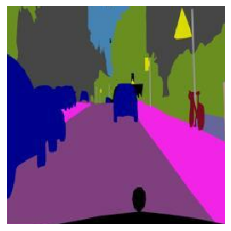

In [ ]:
for tgimg, inimg in train_dataset.take(1):  
  plt.imshow((tgimg[0,...]+1)/2)
  plt.axis("off")
  


# Modelo Generative Adversarial Networks

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  model = Sequential()

  # Ruido normal Gaussiano, con media cero  y desviación estándat 0.02
  initializaer = tf.random_normal_initializer(0, 0.02)

  # Capa convolucional
  model.add(Conv2D(filters, 
                   kernel_size=4,
                   strides=2,
                   padding="same",
                   use_bias=not apply_batchnorm,
                   kernel_initializer=initializaer))

  if apply_batchnorm:
    # Capa BatchNormalization
    model.add(BatchNormalization())

  # Capa de activaciión LeakyRelu
  model.add(LeakyReLU())

  return model

In [ ]:
def upsample(filters, apply_dropout=False):
  model = Sequential()

  # Ruido normal Gaussiano, con media cero  y desviación estándar 0.02
  initializaer = tf.random_normal_initializer(0, 0.02)

  # Capa convolucional
  model.add(Conv2DTranspose(filters, 
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            use_bias=False,
                            kernel_initializer=initializaer))

  
  # Capa BatchNormalization
  model.add(BatchNormalization())

  if apply_dropout:
    # Capa Dropout
    model.add(Dropout(0.5))

  # Capa de activaciión LeakyRelu
  model.add(ReLU())

  return model

In [ ]:
from tensorflow.keras import Model

def generator():
  inputs = Input(shape=[None, None, 3])
  
  # bs: Batch Size
  
  down_stack = [
    downsample(64, apply_batchnorm=False), #(bs, 128, 128, 64) 
    downsample(128), #(bs, 64, 64, 128)
    downsample(256), #(bs, 32, 32, 256)
    downsample(512), #(bs, 16, 16, 512)
    downsample(512), #(bs, 8, 8, 512)
    downsample(512), #(bs, 4, 4, 512)
    downsample(512), #(bs, 2, 2, 512)
    downsample(512) #(bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True), #(bs, 2, 2, 1024) 
    upsample(512, apply_dropout=True), #(bs, 4, 4, 1024)
    upsample(512, apply_dropout=True), #(bs, 8, 8, 1024)
    upsample(512), #(bs, 16, 16, 1024)
    upsample(256), #(bs, 32, 32, 512)
    upsample(128), #(bs, 64, 64, 256)
    upsample(64), #(bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh")
  
  x = inputs
  
  # Skip connections
  s = []
  
  concat = Concatenate()
  
  # Conectamos las capas del generador (codificador)
  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  # Conectamos las capas del decodificador
  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x, sk])

  last = last(x)
  return Model(inputs=inputs, outputs=last)

In [ ]:
generator = generator()

In [ ]:
def discriminator():
  ini = Input(shape=[None, None, 3], name="input_img")
  gen = Input(shape=[None, None, 3], name="gener_img")

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = Conv2D(filters=1,
               kernel_size=4,
               strides=1,
               kernel_initializer=initializer,
               padding="same")(down4)
  
  return Model(inputs=[ini, gen], outputs=last)

In [ ]:
discriminator = discriminator()

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow import ones_like, zeros_like, reduce_mean, abs

loss_object = BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminatorLoss(disc_real_output, disc_generated_output):
  """
  Función de coste para el discriminador
  """
  # Diferencia entre los True por ser real y el detectado por el discriminador
  real_loss = loss_object(ones_like(disc_real_output), disc_real_output)

  # Diferencia entre los False por ser generado y el detectado por el discriminador
  generated_loss = loss_object(zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

# Optimización del modelo


In [ ]:
LAMBDA = 100

def generatorLoss(disc_generated_loss, gen_output, target):
  gen_lost = loss_object(ones_like(disc_generated_loss), disc_generated_loss)

  # MEAN ABSOLUTE ERROR
  l1_loss = reduce_mean(abs(target-gen_output))

  total_gen_loss = gen_lost + (LAMBDA * l1_loss)

  return total_gen_loss

In [ ]:
from tensorflow.keras.optimizers import Adam

# Optimizador

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

In [ ]:
# Checkpoint
checkpoint_prefix = os.path.join(CK_PATH, "ck")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#checkpoint.restore(save_path=tf.train.latest_checkpoint(CK_PATH)).assert_consumed()

In [ ]:
def generatoeImages(model, test_input, tar, save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(GENERATED_IMAGES_PATH+"/output/"+save_filename+".jpg", prediction[0,...])

  plt.figure(figsize=(10,10))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ["Imagen de entrada", "Imagen objetivo", "Imagen generada"]

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i]*0.5 + 0.5)
      plt.axis('off')

    plt.show()

# Entranamiento por GPU

In [ ]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    
    imgi = 0
    for input_image, target in dataset:
      print(f"Epoch {epoch} - train: {imgi}/{len(TRAIN_FILES_LIST[:1000])}")
      imgi += 1
      trainStep(input_image, target) 
    
      clear_output(wait=True)

    imgi = 0
    for inp, tar in test_dataset.take(5):
      generatoeImages(generator, inp, tar, str(imgi)+"_"+str(epoch), display_imgs=True)
      imgi += 1


In [ ]:
@tf.function
def trainStep(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    output_image = generator(input_image, training=True)
    output_gen_discr = discriminator([output_image, input_image], training=True)
    output_trg_discr = discriminator([target, input_image], training=True)
    discr_loss = discriminatorLoss(output_trg_discr, output_gen_discr)
    gen_loss = generatorLoss(output_gen_discr, output_image, target)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

# Resultados del entrenamiento (150 épocas / 1500 imágenes de entranamiento)

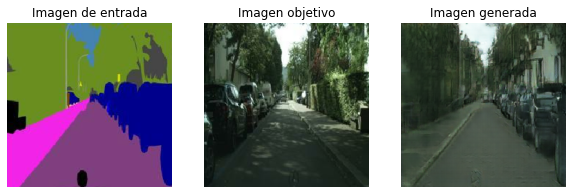

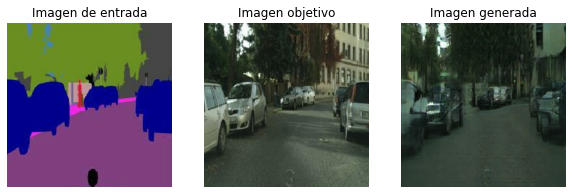

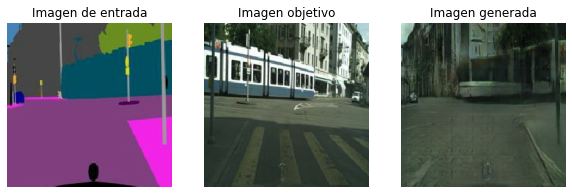

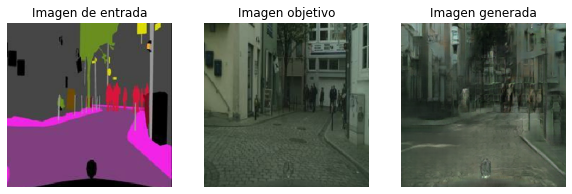

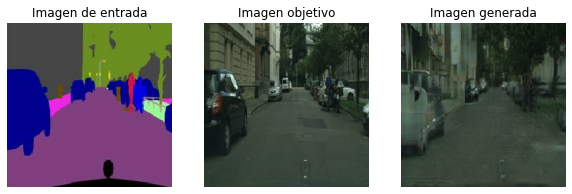

In [ ]:
train(train_dataset, 150)